## Exploring our Dart Throws Dataset

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
HOME_DIR = os.environ['HOME']
ROOT_DIR = HOME_DIR + '/shoot_your_shot'
IMG_DIR = ROOT_DIR + '/bg'
CROP_DIR = ROOT_DIR + '/crops'

In [3]:
raw_imgs = glob(IMG_DIR + '/*_raw.png')
blk_imgs = glob(IMG_DIR + '/*_blk.png')
crop_imgs = glob(CROP_DIR + '/*.png')

Dart Distance from Bullseye: 377 pixels


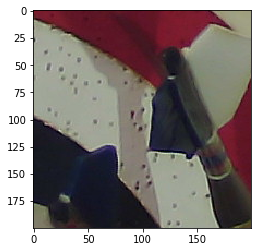

Dart Distance from Bullseye: 143 pixels


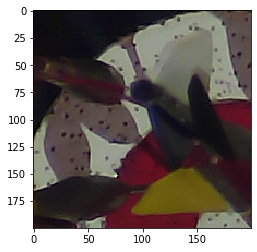

Dart Distance from Bullseye: 224 pixels


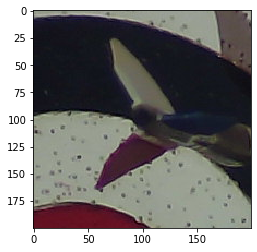

Dart Distance from Bullseye: 130 pixels


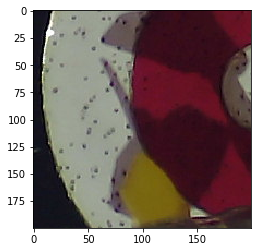

Dart Distance from Bullseye: 486 pixels


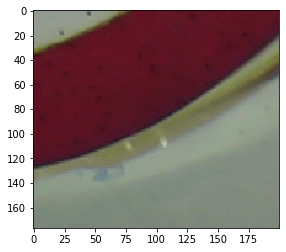

Dart Distance from Bullseye: 203 pixels


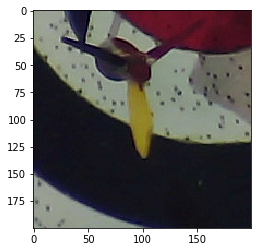

Dart Distance from Bullseye: 245 pixels


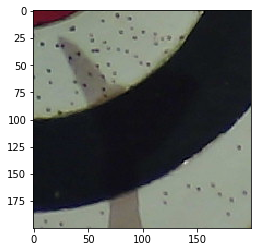

Dart Distance from Bullseye: 168 pixels


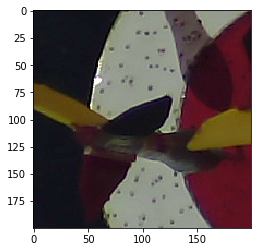

Dart Distance from Bullseye: 195 pixels


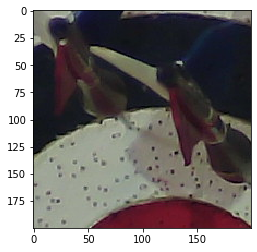

Dart Distance from Bullseye: 187 pixels


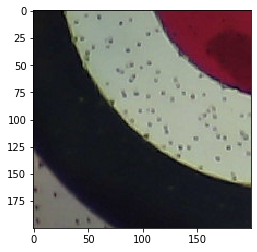

Dart Distance from Bullseye: 181 pixels


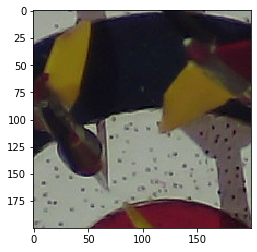

Dart Distance from Bullseye: 382 pixels


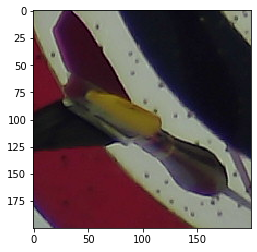

Dart Distance from Bullseye: 489 pixels


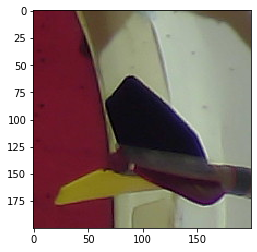

Dart Distance from Bullseye: 361 pixels


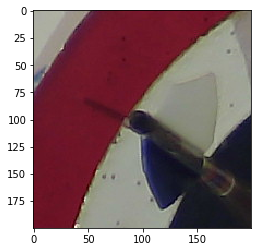

Dart Distance from Bullseye: 153 pixels


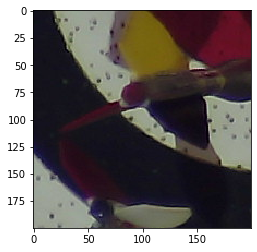

Dart Distance from Bullseye: 311 pixels


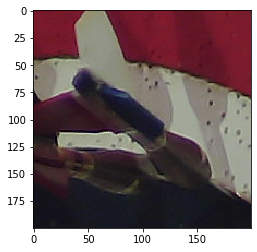

Dart Distance from Bullseye: 518 pixels


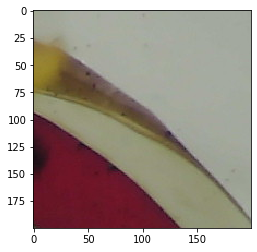

Dart Distance from Bullseye: 510 pixels


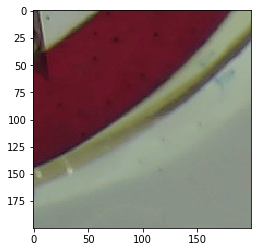

Dart Distance from Bullseye: 337 pixels


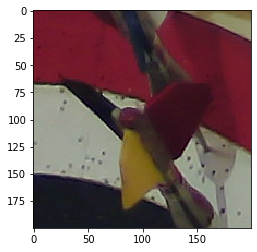

Dart Distance from Bullseye: 283 pixels


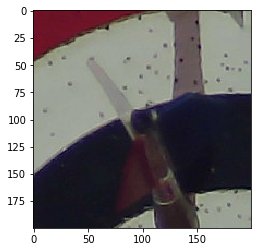

Dart Distance from Bullseye: 371 pixels


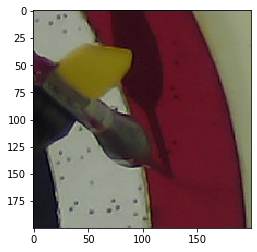

Dart Distance from Bullseye: 157 pixels


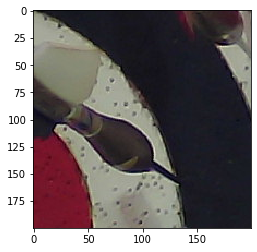

Dart Distance from Bullseye: 200 pixels


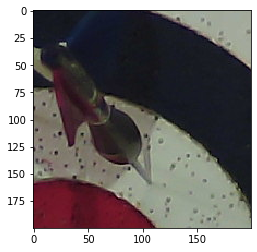

Dart Distance from Bullseye: 249 pixels


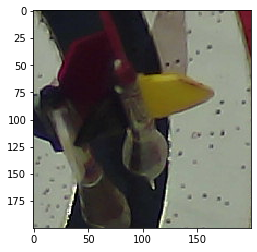

Dart Distance from Bullseye: 287 pixels


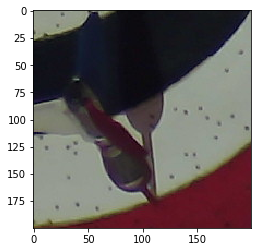

Dart Distance from Bullseye: 263 pixels


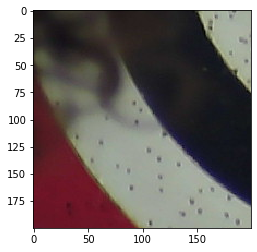

Dart Distance from Bullseye: 192 pixels


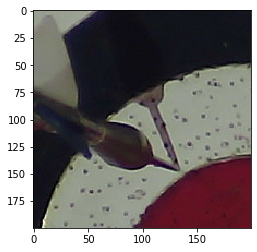

Dart Distance from Bullseye: 313 pixels


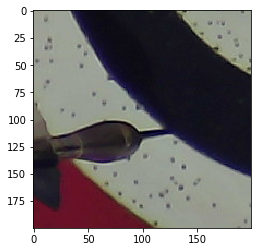

Dart Distance from Bullseye: 220 pixels


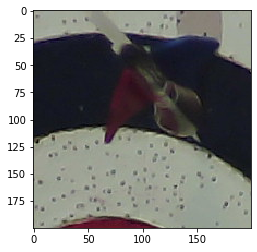

Dart Distance from Bullseye: 207 pixels


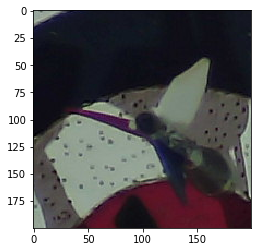

In [4]:
point_lst = []
for idx in range(30):
    try:
        # Load images and convert to RGB to view
        im = cv2.imread(crop_imgs[idx])
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 
        # parse the filename for keypoint and bullseye coords
        x, y, c1, c2 = (crop_imgs[idx].split('shoot_your_shot')[1]).split('_')[1:]
        c2 = int(c2.split('.')[0])
        x, y, c1 = list(map(int, [x, y, c1]))
        print('Dart Distance from Bullseye: {:d} pixels'.format(int(np.linalg.norm(np.array([x, y]) - np.array([c1, c2])))))
        # Add keypoint coordinate to list to visualize the distribution
        point_lst.append((x, y))
        # Plot the Image crop
        plt.imshow(im)
        plt.show()
    except:
        pass

## Visualizing the Distribution of Dart Positions

In [5]:
# https://python-graph-gallery.com/1136-2/

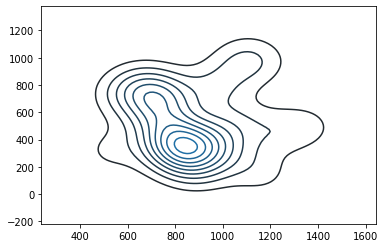

In [6]:
x, y = list(zip(*point_lst))
density_plot = sns.kdeplot(list(x), list(y))
density_plot

In [7]:
n = 10    # Update the Estimated Density after every 10 new images
chunk_lst = [point_lst[i:i + n] for i in range(0, len(point_lst), n)]  # Break the list into chunks of size n

In [ ]:
for idx in range(1, len(chunk_lst)):
    x, y = list(zip(*[x for v in chunk_lst[:idx] for x in v]))  # Add 10 new datapoints
    # Compute the new density plot
    density_plot = sns.kdeplot(list(x), list(y), color='pink')
    density_plot.axis('off')
    fig = density_plot.get_figure()
    # Save as a high resolution image for a video
    fig.savefig(ROOT_DIR + 'density/density_{}.png'.format(idx), transparent=True, format='png', dpi=1200)
    fig.clf()

## Using Simple Features

In [8]:
# https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
from skimage.feature import hog     # Simple feature description for images
from skimage import exposure

In [9]:
# Loading a sample Image
im = cv2.imread('crops/4/1575216600594_706_331_846_532.png')
# Computing the Histogram of Oriented Gradients
fd, hog_image = hog(im, orientations=4, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True) 
# Tune hog parameters to keep fast, simple feature descriptors expressive enough for the dataset

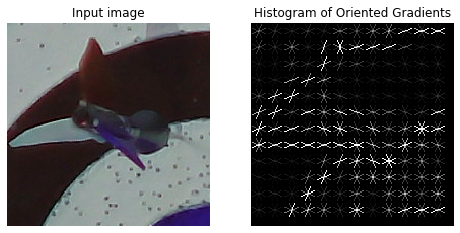

In [10]:
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(im, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [11]:
def cropFeature(img_path):
    im = cv2.imread(img_path)
    im = cv2.resize(im, (200, 200)) 
    fd, hog_image = hog(im, orientations=4, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    x, y, c1, c2 = (img_path.split('shoot_your_shot')[1]).split('_')[1:]
    c2 = int(c2.split('.')[0])
    x, y, c1 = list(map(int, [x, y, c1]))
    dist = np.linalg.norm(np.array([x, y]) - np.array([c1, c2]))
    return np.concatenate((fd, np.expand_dims(dist, axis=0)))

In [12]:
dp_lst = []
for img in glob(ROOT_DIR + '/crops/*/*'):
    *_, dr, fl = img.split('/')
    try:
        dp_lst.append((dr, cropFeature(img)))
    except:
        pass

/home/area51/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


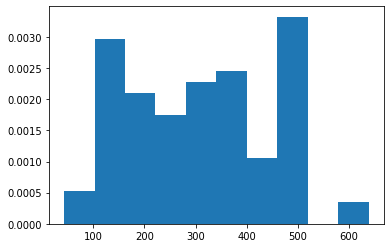

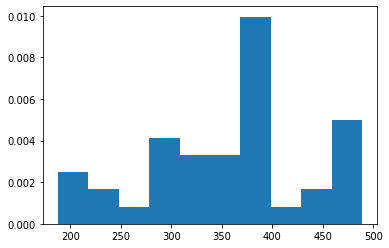

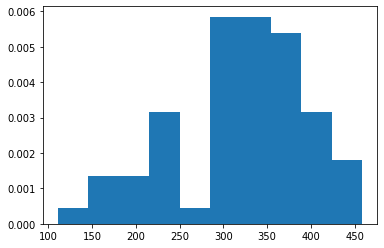

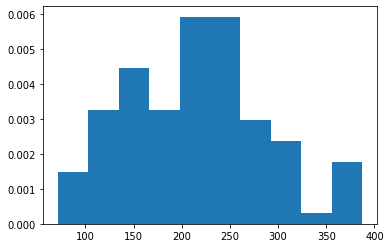

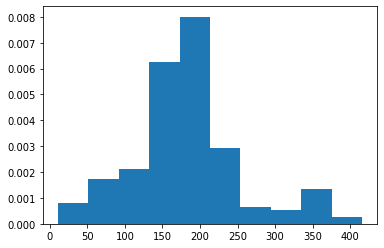

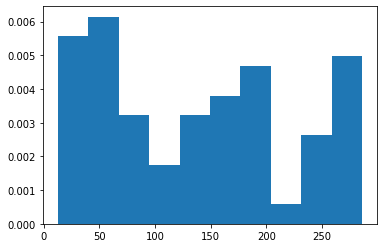

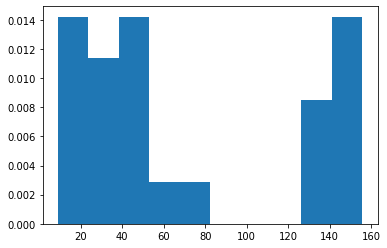

In [13]:
# Notice how the distribution shifts to lower values as the index increases
for idx in range(7):
    hst_lst = [tup[1][-1] for tup in dp_lst if tup[0] == str(idx)]
    plt.hist(hst_lst, normed=True)
    plt.show()

## Use Labeled Data to Train ML Algorithm 

In [14]:
X = []
y = []
for dp in dp_lst:
    X.append(dp[1])
    y.append(dp[0])
X = np.stack(X)
y = np.array(y)

In [15]:
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators=500, max_depth=5, learning_rate=0.01)

In [16]:
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [17]:
def img_eval(img_path):
    ft_vec = cropFeature(img_path)
    return clf.predict(np.expand_dims(ft_vec, axis=0))[0]

In [18]:
img_eval('/home/area51/shoot_your_shot/crops/1575225772110_853_581_878_535.png')

'5'